In [1]:
## For the following activity, we will implement the actions defined in the exercise to 
## reduce the high bias that is affecting the performance of the model. 

In [1]:
## Import the same libraries as in the previous activity.
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [3]:
data = pd.read_csv("dccc_prepared.csv")
X = data.iloc[:,:-1]
y = data["default.payment.next.month"]
X_new, X_test, y_new, y_test = train_test_split(X, y, test_size=0.2,  
random_state=0)
dev_per = X_test.shape[0]/X_new.shape[0]
X_train, X_dev, y_train, y_dev = train_test_split(X_new, y_new,  
test_size=dev_per, random_state=0)
X_dev_torch = torch.tensor(X_dev.values).float()
y_dev_torch = torch.tensor(y_dev.values)
X_test_torch = torch.tensor(X_test.values).float()
y_test_torch = torch.tensor(y_test.values)

In [5]:
# class defining model's architecture and operations between layers
class Classifier(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.hidden_1 = nn.Linear(input_size, 100)
        self.hidden_2 = nn.Linear(100, 100)
        self.hidden_3 = nn.Linear(100, 50)
        self.hidden_4 = nn.Linear(50,50)
        self.output = nn.Linear(50, 2)
        self.dropout = nn.Dropout(p=0.1)
        #self.dropout_2 = nn.Dropout(p=0.1)
    def forward(self, x):
        z = self.dropout(F.relu(self.hidden_1(x)))
        z = self.dropout(F.relu(self.hidden_2(z)))
        z = self.dropout(F.relu(self.hidden_3(z)))
        z = self.dropout(F.relu(self.hidden_4(z)))
        out = F.log_softmax(self.output(z), dim=1)
        return out
# parameters definition
model = Classifier(X_train.shape[1])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 3000
batch_size = 128
# training process
train_losses, dev_losses, train_acc, dev_acc= [], [], [], []
x_axis = []
for e in range(1, epochs + 1):
    X_, y_ = shuffle(X_train, y_train)
    running_loss = 0
    running_acc = 0
    iterations = 0
    for i in range(0, len(X_), batch_size):
        iterations += 1
        b = i + batch_size
        X_batch = torch.tensor(X_.iloc[i:b,:].values).float()
        y_batch = torch.tensor(y_.iloc[i:b].values)
        log_ps = model(X_batch)
        loss = criterion(log_ps, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        running_acc += accuracy_score(y_batch, top_class)
    dev_loss = 0
    acc = 0
    # Turn off gradients for validation, saves memory and computations  
    with torch.no_grad():
        log_dev = model(X_dev_torch)
        dev_loss = criterion(log_dev, y_dev_torch)
        ps_dev = torch.exp(log_dev)
        top_p, top_class_dev = ps_dev.topk(1, dim=1)
        acc = accuracy_score(y_dev_torch, top_class_dev)
    if e%50 == 0 or e == 1:
        x_axis.append(e)
        train_losses.append(running_loss/iterations)
        dev_losses.append(dev_loss)
        train_acc.append(running_acc/iterations)
        dev_acc.append(acc)
        print("Epoch: {}/{}.. ".format(e, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/ 
                                                iterations),
              "Validation Loss: {:.3f}.. ".format(dev_loss),
              "Training Accuracy: {:.3f}.. ".format(running_acc/ 
                                                    iterations),
              "Validation Accuracy: {:.3f}".format(acc))

Epoch: 1/3000..  Training Loss: 0.532..  Validation Loss: 0.478..  Training Accuracy: 0.750..  Validation Accuracy: 0.800
Epoch: 50/3000..  Training Loss: 0.424..  Validation Loss: 0.440..  Training Accuracy: 0.823..  Validation Accuracy: 0.815
Epoch: 100/3000..  Training Loss: 0.405..  Validation Loss: 0.454..  Training Accuracy: 0.830..  Validation Accuracy: 0.807
Epoch: 150/3000..  Training Loss: 0.390..  Validation Loss: 0.489..  Training Accuracy: 0.835..  Validation Accuracy: 0.807
Epoch: 200/3000..  Training Loss: 0.377..  Validation Loss: 0.523..  Training Accuracy: 0.841..  Validation Accuracy: 0.804
Epoch: 250/3000..  Training Loss: 0.365..  Validation Loss: 0.526..  Training Accuracy: 0.848..  Validation Accuracy: 0.808
Epoch: 300/3000..  Training Loss: 0.357..  Validation Loss: 0.562..  Training Accuracy: 0.851..  Validation Accuracy: 0.800
Epoch: 350/3000..  Training Loss: 0.352..  Validation Loss: 0.593..  Training Accuracy: 0.853..  Validation Accuracy: 0.797
Epoch: 400/

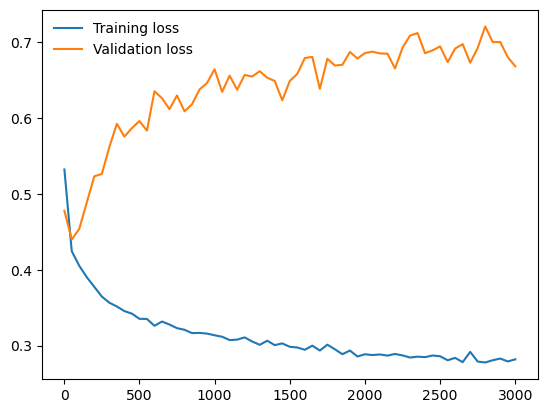

In [6]:
## Plot the loss and accuracy for both sets of data:
 
plt.plot(x_axis,train_losses, label='Training loss')
plt.plot(x_axis, dev_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

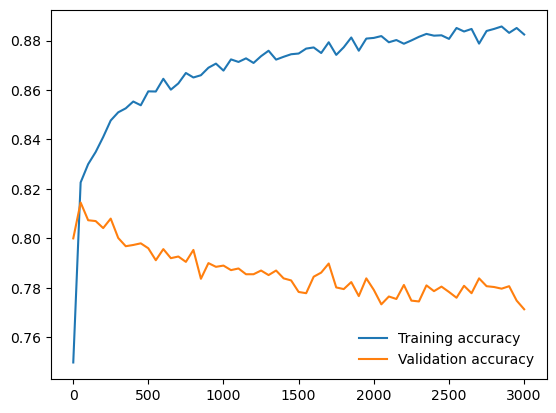

In [8]:
plt.plot(x_axis, train_acc, label="Training accuracy")
plt.plot(x_axis, dev_acc, label="Validation accuracy")
plt.legend(frameon=False)
plt.show()

In [10]:
model.eval()
test_pred = model(X_test_torch)
test_pred = torch.exp(test_pred)
top_p, top_class_test = test_pred.topk(1, dim=1)
acc_test = accuracy_score(y_test_torch, top_class_test)

In [11]:
print(acc_test)

0.7845


In [13]:
# After training the model (assuming the model has been trained here)
# Save the checkpoint
checkpoint = {
    'input_size': X_train.shape[1],
    'state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'hidden_1_units': 100,
    'hidden_2_units': 100,
    'hidden_3_units': 50,
    'hidden_4_units': 50,
    'output_units': 2,
    'learning_rate': 0.001,  
    'epochs': 3000  
}

torch.save(checkpoint, 'checkpoint.pth')